In [1]:
import pandas as pd
import numpy as np
import cv2   
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn import svm, metrics, datasets

from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD


from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [3]:
# We can set all important variables at the start
main_folder = 'C://Users/karim/Desktop/'
images_folder = main_folder +'clean_AMLSdataset_mediumset/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 15

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('clean_attribute_list_mediumset.csv')
df_attr.set_index('file_name', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(1000, 5)

In [5]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human      0
Name: 1.png, dtype: int64

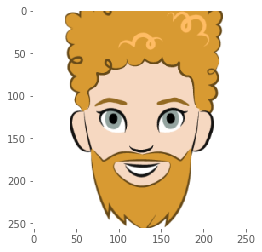

In [6]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

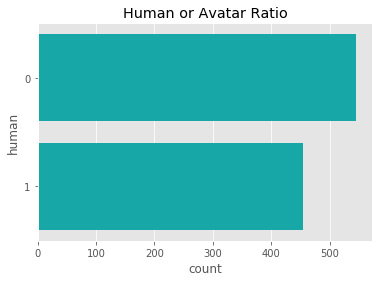

In [7]:
# Character or Noise?
plt.title('Human or Avatar Ratio')
sns.countplot(y='human', data=df_attr, color="c")
plt.show()

In [8]:
df_partition = pd.read_csv('clean_list_eval_partition_mediumset.csv')
df_partition.head()

,file_name,partition
0,1.png,0
1,2.png,0
2,3.png,0
3,7.png,0
4,8.png,0


In [9]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [10]:
# join the partition with the attributes
df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['human'], how='inner')
#df_par_attr.tail(100)
df_par_attr['human'].value_counts().sort_index()

0    546
1    454
Name: human, dtype: int64

In [11]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(100))
    
    #print(df_)
    
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(100))])
    #print(df_)
    

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)
    
    return x_, y_

In [12]:
def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(50))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])
    


    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)

    return x_, y_

In [13]:
def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(50))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])

    x_ = []
    y_ = []

    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

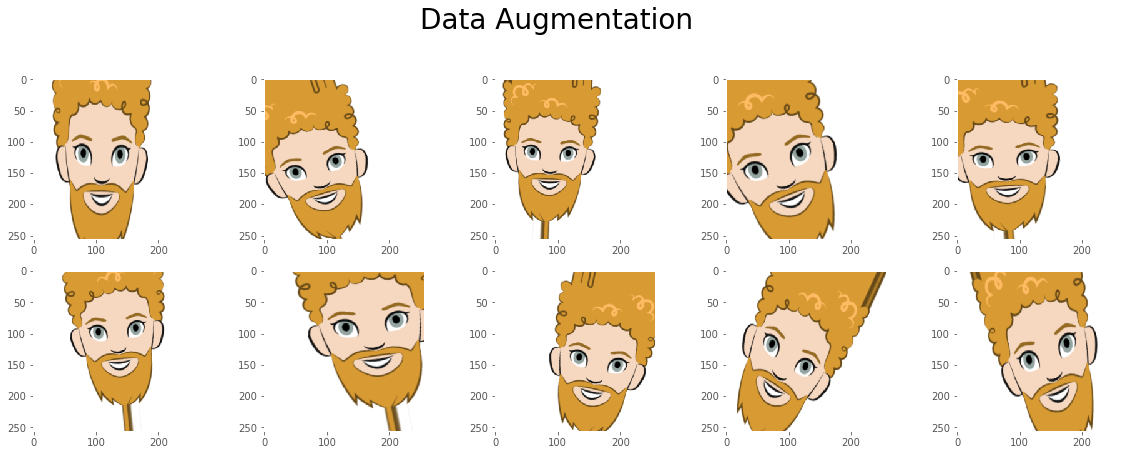

In [14]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [16]:
# Train data
x_train, y_train = generate_df_TRAIN(0, 'human', TRAINING_SAMPLES)

#print(x_train)
#print(y_train)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

#print(x_train)
#print(y_train)

In [18]:
#Define function that allows to flatten the features
def flattener(tr_X):
    x_new=[]
    for i in tr_X:
        x_new.append(i.flatten())
    x_new=np.array(x_new)
    return x_new

In [19]:
x_train_fff = flattener(x_train)
#x_train_fff

In [20]:
y_train_single = [i[0] for i in y_train]
#y_train_single

In [21]:
classifier = svm.SVC(degree=1, kernel='rbf')
classifier.fit(x_train_fff, y_train_single)


c:\users\karim\anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
# classifier = svm.SVC(degree=3, kernel='poly')
# classifier.fit(x_train_fff, y_train_single)

In [22]:
y_pred=classifier.predict(x_train_fff)

In [23]:
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
val_accuracy = accuracy_score(y_train_single, y_pred)
val_accuracy

0.945

In [25]:
print("Confusion matrix:\n%s" % confusion_matrix(y_train_single, y_pred))

Confusion matrix:
[[97  3]
 [ 8 92]]


In [26]:
# Test Data
x_test, y_test = generate_df_TEST(2, 'human', TEST_SAMPLES)

In [27]:
#x_test

In [28]:
test_pred = classifier.predict(flattener(x_test))

In [29]:
test_pred

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [30]:
test_accuracy = accuracy_score(test_pred, y_test)
test_accuracy

0.04

In [31]:
#classifier.summary()

In [32]:
# # Test Data
# x_test, y_test = generate_df_TEST(2, 'eyeglasses', TEST_SAMPLES)


# # generate prediction
# model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]


# report test accuracy
test_accuracy = 100 * np.sum(np.array(test_pred)==y_test) / len(test_pred)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, test_pred))

print(test_pred)


Model Evaluation
Test accuracy: 4.0000%
f1_score: 0.04
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [45]:
#dictionary to name the prediction
attribute_target = {0: 'Avatar'
                , 1: 'Human'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display results in HTML for better visualisation
    
    '''

    attribute = 'Human'
    arrow_icon = "https://upload.wikimedia.org/wikipedia/commons/4/45/Arrow_Blue_Right_001.svg"
    
    #print(prediction)
    
    if prediction[0] <= 0.5:
        arrow_icon = "https://upload.wikimedia.org/wikipedia/commons/4/45/Arrow_Blue_Right_001.svg"
        attribute = 'Avatar'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , arrow_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [46]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    im_new = flattener(im)
    #print(im_new)
    
    # prediction
    result = classifier.predict(im_new)

    return result
    

[1.]



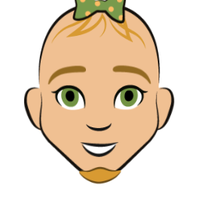

[1.]



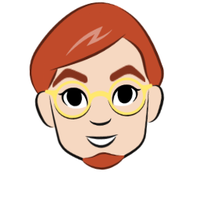

[0.]



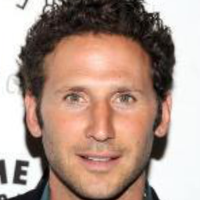

[1.]



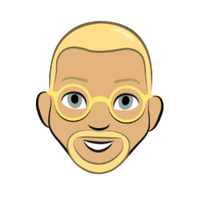

[1.]



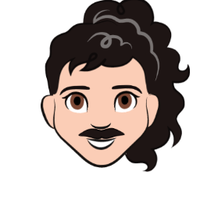

[1.]



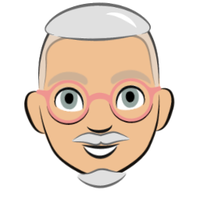

[0.]



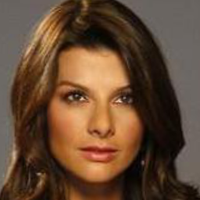

[0.]



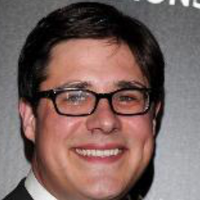

[0.]



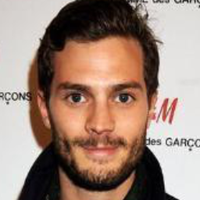

[0.]



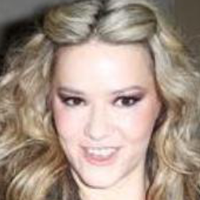

[1.]



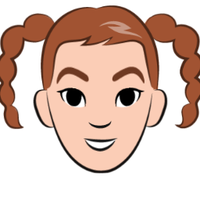

[1.]



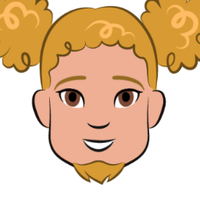

[1.]



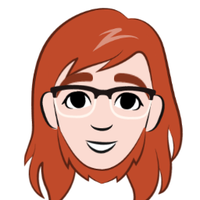

[0.]



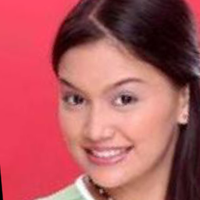

[1.]



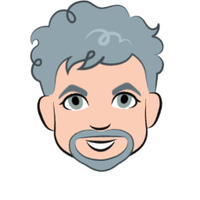

[0.]



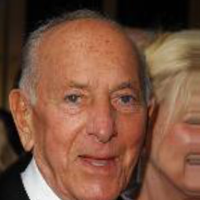

[1.]



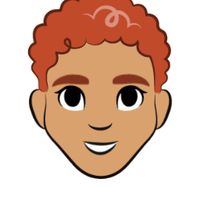

[1.]



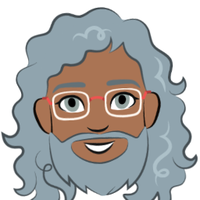

[0.]



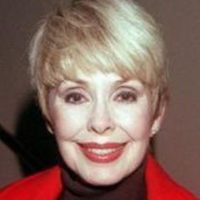

[0.]



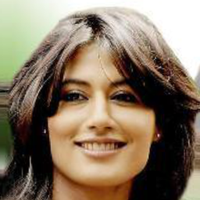

[1.]



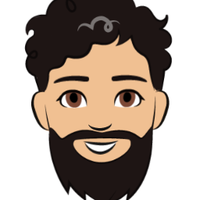

[0.]



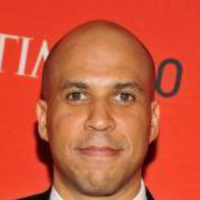

[1.]



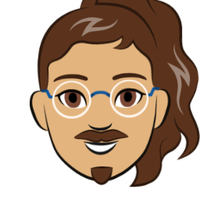

[1.]



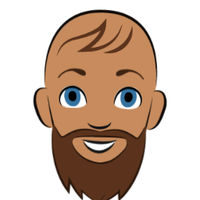

[1.]



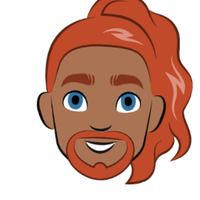

[1.]



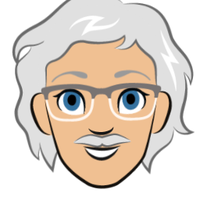

[0.]



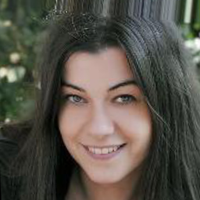

[1.]



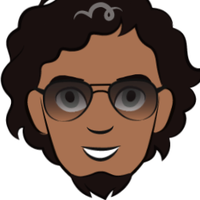

[1.]



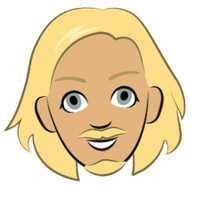

[1.]



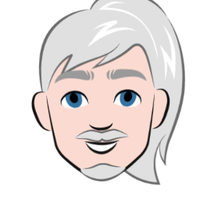

[1.]



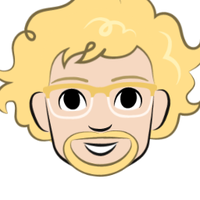

[0.]



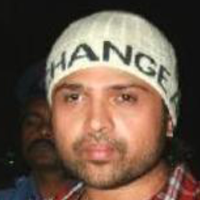

[1.]



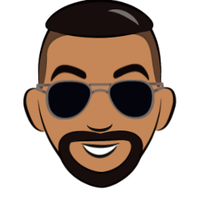

[0.]



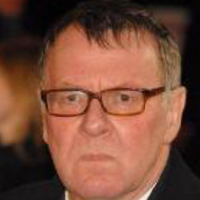

[0.]



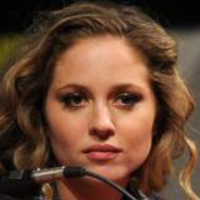

[0.]



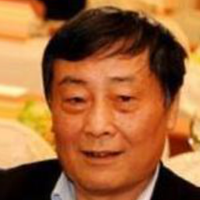

[1.]



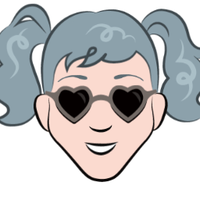

[0.]



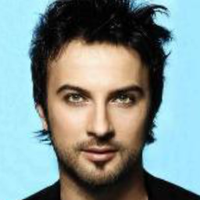

[1.]



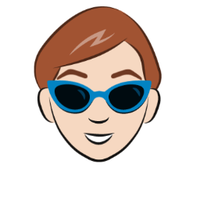

[1.]



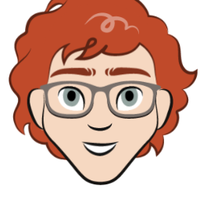

[1.]



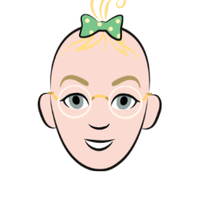

[1.]



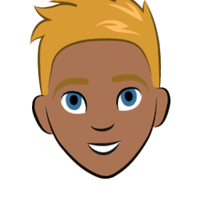

[1.]



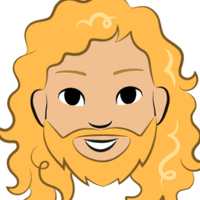

[1.]



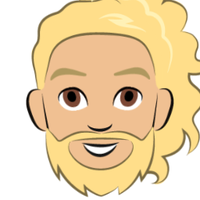

[1.]



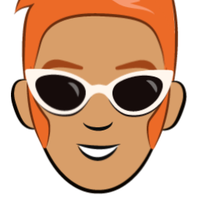

[1.]



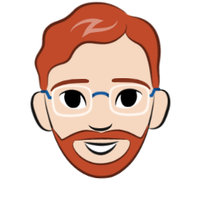

[0.]



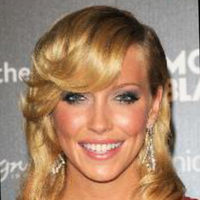

[1.]



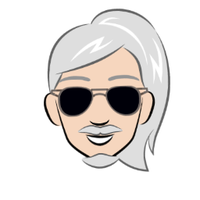

[1.]



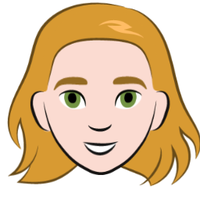

[1.]



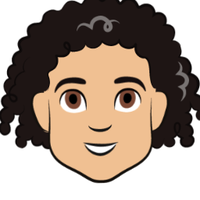

In [47]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(50)

for index, target in df_to_test.iterrows():
    result = attribute_prediction(images_folder + index)
    print(result)
    #display result
    display_result(images_folder + index, result, target['human'])